# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. Для оценки качества моделей необходимо применять метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

Важные параметры:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
```
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
Repaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
```
Целевой признак
```
Price — цена (евро)
```

## Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor

### Загрузка и изучение данных

Загрузим данные:

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
data[:4].transpose()

,0,1,2,3
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04
Price,480,18300,9800,1500
VehicleType,NaN,coupe,suv,small
RegistrationYear,1993,2011,2004,2001
Gearbox,manual,manual,auto,manual
Power,0,190,163,75
Model,golf,NaN,grand,golf
Kilometer,150000,125000,125000,150000
RegistrationMonth,0,5,8,6
FuelType,petrol,gasoline,gasoline,petrol


Уже на этом этапе можно сказать, что для дальнейшей работы не понадобятся некоторые столбцы, которые не влияют на цену. А именно дата загрузки анкеты, месяц регистрации (достаточно года), дата создания анкеты, количество фотографий, а так же когда в последний раз был в сети пользователь. Перед этим узнаем только, когда были выгружены в последний раз данные, чтобы убрать в дальнейшем возможные ошибки со временем.

In [5]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCrawled'].min()

Timestamp('2016-03-05 14:06:22')

Последний раз выгружали данные в 2016 году.

In [6]:
data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

Выведем информацию о данных:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Переименуем оставшиеся столбцы:

In [8]:
data = data.rename(columns={'VehicleType': 'Vehicle_Type', 'RegistrationYear': 'Registration_Year', 'FuelType':'Fuel_Type'})
data.columns = data.columns.str.lower()
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Проверка на дубликаты

In [9]:
data.duplicated().sum()

45040

Удалим дубликаты:

In [10]:
data.drop_duplicates(inplace = True)

Выведем для удобства столбцы с категориальными значениями и количественными:

In [11]:
categorical_columns = ['vehicle_type','gearbox','model', 'fuel_type', 'brand', 'repaired']
numerical_columns = ['registration_year','power','kilometer']

Изучим их уникальные значения, чтобы по возможности проверить на неявные дубликаты:

In [12]:
for column in data[categorical_columns].columns:
    unique_values = data[column].unique()
    print(f"Unique values of {column}: {unique_values}\n\n")

Unique values of vehicle_type: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


Unique values of gearbox: ['manual' 'auto' nan]


Unique values of model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'mat

Неявных дубликатов не обнаружено, но обнаружены пропуски. Заполним их словом 'Unknown':

In [13]:
data[categorical_columns] = data[categorical_columns].fillna(value='Unknown')

### Проверка на пропуски

In [14]:
display(data.isna().sum())

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Пропусков нет.

### Проверка на выбросы

Проверим столбцы с количественными столбцами на выбросы:

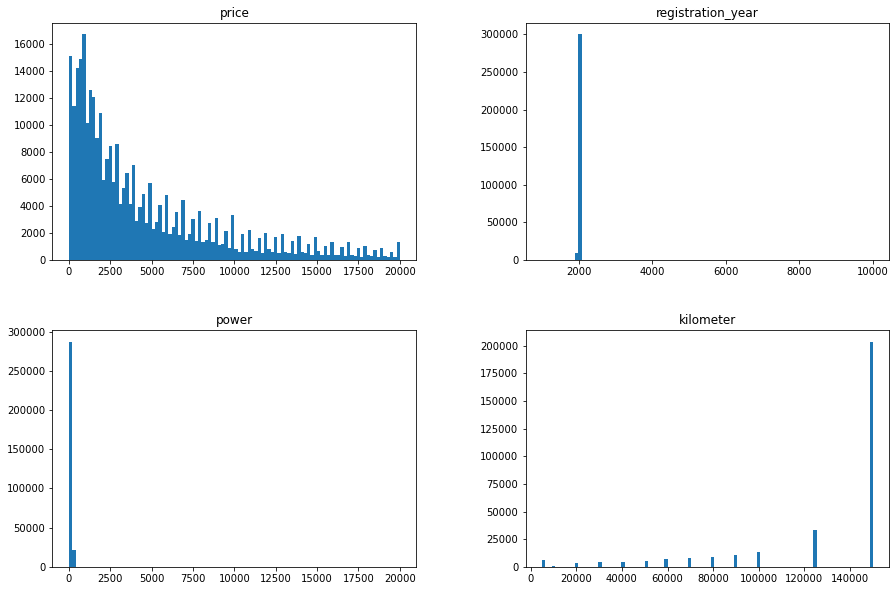

In [15]:
data.hist(figsize=(15, 10), bins=100, grid=False);

Есть очевидные выбросы в годе регистрации и мощности двигателя:

Вызовем метод describe():

In [16]:
data.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В минимальных и максимальных значениях уже есть некорректные числа. Изучим еще данные с помощью квантилей:

In [17]:
data.quantile([0.0012, 0.01, .5, .99, .9988]).style.format("{:,.2f}")

,price,registration_year,power,kilometer
0.001200,0.00,"1,959.00",0.00,"5,000.00"
0.010000,0.00,"1,979.00",0.00,"5,000.00"
0.500000,"2,800.00","2,003.00",105.00,"150,000.00"
0.990000,"18,900.00","2,018.00",306.00,"150,000.00"
0.998800,"19,999.00","2,018.00",603.00,"150,000.00"


Напишем функцию по удалению выбивающихся значений:

In [18]:
def remove_outliers(data, outliers_dict):
    for col, (min_val, max_val) in outliers_dict.items():
        data = data[(data[col] > min_val) & (data[col] <= max_val)]
    return data

Подставим необходимые нам значения, опираясь на квантили, а так же вспоминая, что позже 2016 года не было данных:

In [19]:
outliers_dict = {
    'price': (0, 20000),
    'registration_year': (1979, 2016),
    'power': (25, 306),
    'kilometer': (4999, 150000)
}

data = remove_outliers(data, outliers_dict)

Еще раз взглянем на графики:

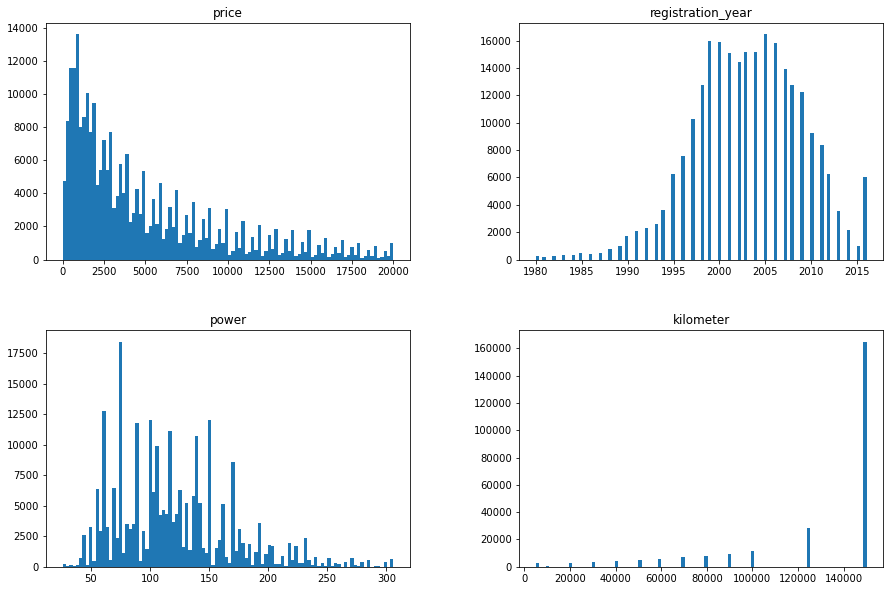

In [20]:
data.hist(figsize=(15, 10), bins=100, grid=False);

Теперь все хорошо.

Посмотрим на наличие корреляции:

In [21]:
data.corr()

,price,registration_year,power,kilometer
price,1.000000,0.564003,0.494914,-0.387763
registration_year,0.564003,1.000000,0.125970,-0.356062
power,0.494914,0.125970,1.000000,0.120771
kilometer,-0.387763,-0.356062,0.120771,1.000000


Между ценой и годом регистрации есть средняя положительная корреляция, слабая корреляция между мощностью и ценой, а так же отрицательная корреляция между ценой и пробегом.

### Разбивка на выборки

Следующий этап - разбивка данных на признаки и целевые признаки, а так же на тренировочную и тестовые выборки.

Разобьем на признаки и целевые признаки:

In [24]:
target = data['price']

features = data.drop('price', axis = 1)

Для разбития данных на выборки используем train_test_split. Сначала разобьем на тренировочную выборку train и выборку для проверки check в соотношении 60% и 40%, потом выборку для проверки check разобьем пополам, чтобы получилось по 20% от всей выборки на валидационную valid и тестовую test выборки:

In [25]:
features_train, features_check, target_train, target_check, = train_test_split(
    features, target, test_size=0.40, random_state=12345)

In [26]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_check, target_check, test_size=0.50, random_state=12345)

### Масштабирование и кодирование признаков

Теперь создадим преобразователь, он кодируем категориальные и масштабирует количественные признаки, обучим его на тренировочной выборке:

In [27]:
codescale = make_column_transformer((StandardScaler(), numerical_columns),
                             (OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), categorical_columns),
                             remainder='passthrough', verbose_feature_names_out=False)

codescale.fit(features_train)


ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['registration_year', 'power', 'kilometer']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired'])],
                  verbose_feature_names_out=False)

Применим его к выборкам:

In [28]:
features_train = pd.DataFrame(codescale.transform(features_train), columns= codescale.get_feature_names_out())
features_valid = pd.DataFrame(codescale.transform(features_valid), columns= codescale.get_feature_names_out())
features_test = pd.DataFrame(codescale.transform(features_test), columns= codescale.get_feature_names_out())

Нами были обработаны данные, убраны лишние столбцы, удалены дубликаты и заполнены пропуски. Данные были отчищены от выбросов. Было проведено маштабирование количественных и кодирование категориальных признаков. Для дальнейшей работы данные были разбиты на учебную, валидационную и тестовую выборки.

## Обучение моделей

Теперь займемся обучением моделей: линейной регрессии, модели случайного леса и модели LightGBM.

Сначала напишем функцию для определения средней квадратичной ошибки, чтобы определять качество моделей:

In [29]:
def rmse(target, predictions):
    score = np.sqrt(mean_squared_error(target, predictions))
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Линейная регрессия:

Начнем с модели линейной регрессии, подбирать параметры для нее не нужно:

In [30]:
%%time

LR_model = LinearRegression()
LR_model.fit(features_train, target_train)

CPU times: total: 9.8 s
Wall time: 1.74 s


LinearRegression()

Время обучения: 2 секунды.

In [31]:
%%time

print("Значение RMSE для модели LightGBM %.2f" % rmse(target_valid, LR_model.predict(features_valid)))

Значение RMSE для модели LightGBM 2406.44
CPU times: total: 375 ms
Wall time: 37 ms


Время предсказания 35 милисекунд, показатель средней квардатичной ошибки: 2406,44

### Модель случайного леса

In [32]:
%%time
RFG_model = RandomForestRegressor(random_state=12345)

param_grid = {'n_estimators': [100, 200],
              'max_depth': [20, 30,]
             }

gsearch = GridSearchCV(RFG_model, param_grid, cv=2, scoring=rmse_scorer, n_jobs=-1, verbose=10)

gsearch.fit(features_train, target_train)

print('Лучший показатель RandomForestRegressor модели:', -gsearch.best_score_
      ,'\n При глубине и количестве деревьев:', gsearch.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Лучший показатель RandomForestRegressor модели: 1661.645265992633 
 При глубине и количестве деревьев: {'max_depth': 20, 'n_estimators': 200}
CPU times: total: 7min 27s
Wall time: 13min 51s


Время на подбор модели: 13 минут

Теперь обучим модель в соответствии с лучшими параметрами:

In [33]:
%%time
RFG_model = RandomForestRegressor(random_state=12345, max_depth = 20, n_estimators = 200)
RFG_model.fit(features_train, target_train)

CPU times: total: 7min 26s
Wall time: 7min 26s


RandomForestRegressor(max_depth=20, n_estimators=200, random_state=12345)

Время на обучение 7 минут.

Предскажем результат:

In [34]:
%%time
print("Значение RMSE для модели случаного леса %.2f" % rmse(target_valid, RFG_model.predict(features_valid)))

Значение RMSE для модели случаного леса 1607.08
CPU times: total: 2.44 s
Wall time: 2.42 s


Время предсказания 2 секунды, показатель средней квардатичной ошибки: 1607,08

### Модель LightGBM

Теперь подберем параметры для модели LightGBM:

In [35]:
%%time
LGBM_model = LGBMRegressor(random_state=12345)

param_grid = {'n_estimators': range(100, 2001, 100),
              'max_depth': [10, 20, 30]
             }

gsearch = GridSearchCV(LGBM_model, param_grid, cv=2, scoring=rmse_scorer, n_jobs=-1, verbose=10)

gsearch.fit(features_train, target_train)

print('Лучший показатель LightGBM модели:', -gsearch.best_score_
      ,'\n При глубине и количестве деревьев:', gsearch.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
Лучший показатель LightGBM модели: 1555.2440476228965 
 При глубине и количестве деревьев: {'max_depth': 30, 'n_estimators': 1200}
CPU times: total: 34 s
Wall time: 6min 4s


Время затраченное на поиск параметров: 6 минут

Теперь обучим модель в соответствии с лучшими параметрами:

In [36]:
%%time
LGBM_model = LGBMRegressor(random_state=12345, max_depth = 10, n_estimators = 1900)
LGBM_model.fit(features_train, target_train)

CPU times: total: 46.4 s
Wall time: 3.35 s


LGBMRegressor(max_depth=10, n_estimators=1900, random_state=12345)

Время обучения 4 секунды.

Предскажем результат:

In [37]:
%%time
print("Значение RMSE для модели LightGBM %.2f" % rmse(target_valid, LGBM_model.predict(features_valid)))

Значение RMSE для модели LightGBM 1516.05
CPU times: total: 14.5 s
Wall time: 1.02 s


Время предсказания 1 секунда, показатель средней квардатичной ошибки: 1516,05

### Dummy-модель

Для контроля качетва еще обучим dummy-модель:

In [38]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)

DummyRegressor()

И узнаем качество ее предскадания:

In [39]:
rmse(target_valid, dummy_model.predict(features_valid))

4583.172456875722

Все модели показали качество лучше, чем dummy-модель, значит прошли проверку на адекватность.

Мы провели обучение и проверку трех моделей - линейной регрессии, случайного леса и LightGBM. Хуже всего себя показала модель линейной регрессии. По времени дольше всего обучалась и предсказывала модель случайного леса. Лучший результат метрики средней квадратичной ошибки показала модель LightGBM, так же показав небольшое время на обучение и предсказание. Все мдели прошли проверку на адекватность, показав результат лучше чем dummy-модель.

Следующим шагом проверим лучшую модель на тестовой выборке.

## Анализ моделей

Осталось проверить как лучшая модель LightGBM покажет себя на тестовой выборке и сможет пройти проверку, показатель RMSE должен быть ниже 2500.

In [40]:
print("Значение RMSE для модели LightGBM на тестовой выборке %.2f" % rmse(target_test, LGBM_model.predict(features_test)))

Значение RMSE для модели LightGBM на тестовой выборке 1540.74


Проверку модель прошла.

Общий вывод:

Нами были обработаны данные, для обучения моделей, разбиты на учебную, валидационную и тестовую выборки. На учебной выборке были обучены и настроены модель линейной регрессии, случайного леса и LightGBM. На валидационной выборке были проверены их показатели метрики RMSE, лучший результат показала модель LightGBM. Она так же показала лучшее время по обучению, подбору параметров и предсказанию. Она была выбрана для дальнейшей работы и показала необходимый результат метрики RMSE для применения в дальнейшей рабое на тестовой выборке.